In [1]:
# !pip install -q git+https://github.com/tensorflow/examples.git
#https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-u-net-for-image-segmentation-with-tensorflow-and-keras.md

In [2]:
from commons import unet_models

2022-04-12 14:47:54.864542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 14:47:54.864558: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import tensorflow as tf
import numpy as np
from glob import glob
from commons import load_images_from_directory_resize
from sklearn.model_selection import train_test_split

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt
from commons import plot
from keras import backend as K

In [5]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return np.asarray(pred_mask).reshape(DIM, DIM)

In [6]:
OUTPUT_CHANNELS = 3
DIM = 224

In [7]:
def unet_model(output_channels):
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=[DIM, DIM, 3], include_top=False)

    # Use as ativações dessas camadas
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Crie o modelo de extração de características
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False
    
    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]
    
    # Esta é a última camada do modelo
    last = tf.keras.layers.Conv2DTranspose(output_channels,
                                           3,
                                           strides=2,
                                           padding='same', 
                                           activation='softmax') 

    inputs = tf.keras.layers.Input(shape=[DIM, DIM, 3])
    x = inputs

    # Downsampling através do modelo
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling e estabelecimento das conexões de salto
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
model = unet_model(OUTPUT_CHANNELS)
# model = unet_models.vgg19.build((224, 224, 3))

model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer='rmsprop',
#               loss=[jacard_coef_loss], 
#               metrics=[jacard_coef])

In [9]:
%%time
images = load_images_from_directory_resize(glob('data/images/*'), dim=(DIM, DIM))
masks = load_images_from_directory_resize(glob('data/masks_bin/*'), dim=(DIM, DIM))

100%|███████████████████████████████████████████| 27/27 [00:15<00:00,  1.77it/s]

CPU times: user 1min 4s, sys: 3.24 s, total: 1min 7s
Wall time: 1min 7s


In [10]:
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    masks,  
                                                    test_size=0.2, 
                                                    random_state=42)

In [19]:
EPOCHS = 200

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unet_model.h5", save_best_only=True)
]

model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=8, 
                          verbose=1, 
                          epochs=EPOCHS, 
                          validation_split=0.1,
                          callbacks=callbacks, 
                          shuffle=False)

Epoch 1/20
2/2 [==============================] - 3s 734ms/step - loss: 1.9073 - accuracy: 0.1992 - val_loss: 0.8405 - val_accuracy: 0.5967
Epoch 2/20
2/2 [==============================] - 1s 162ms/step - loss: 0.6997 - accuracy: 0.6445 - val_loss: 1.2695 - val_accuracy: 0.2999
Epoch 3/20
2/2 [==============================] - 1s 158ms/step - loss: 0.4296 - accuracy: 0.8539 - val_loss: 1.6070 - val_accuracy: 0.3228
Epoch 4/20
2/2 [==============================] - 1s 160ms/step - loss: 0.3312 - accuracy: 0.8977 - val_loss: 1.5916 - val_accuracy: 0.3104
Epoch 5/20
2/2 [==============================] - 1s 160ms/step - loss: 0.2678 - accuracy: 0.9150 - val_loss: 1.3271 - val_accuracy: 0.3417
Epoch 6/20
2/2 [==============================] - 1s 163ms/step - loss: 0.2084 - accuracy: 0.9358 - val_loss: 1.3602 - val_accuracy: 0.3871
Epoch 7/20
2/2 [==============================] - 1s 160ms/step - loss: 0.1871 - accuracy: 0.9383 - val_loss: 1.2143 - val_accuracy: 0.5068
Epoch 8/20
2/2 [====

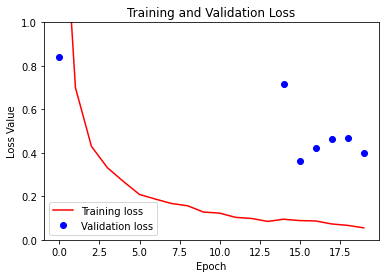

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [21]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 132ms/step - loss: 0.6281 - accuracy: 0.8119


[0.628089964389801, 0.8119253516197205]

In [22]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

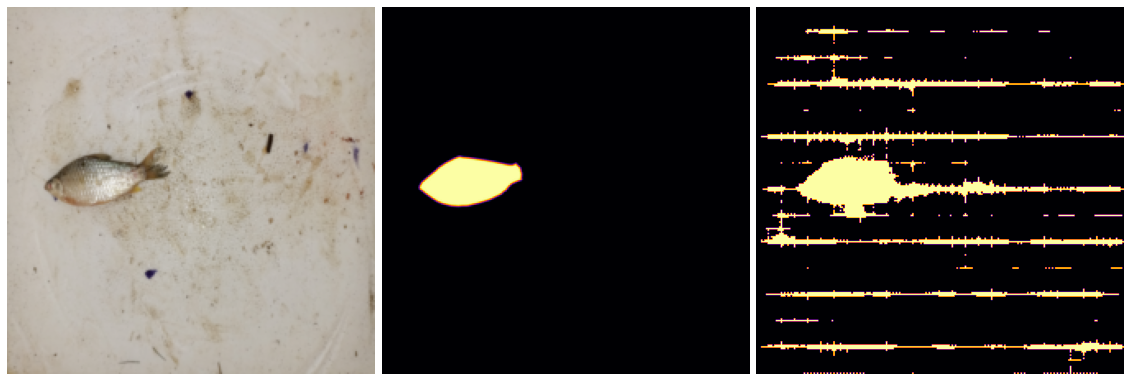

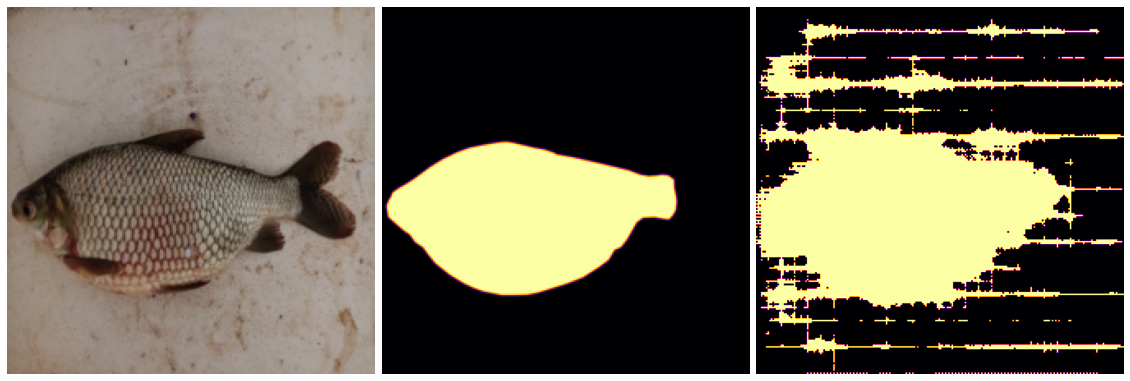

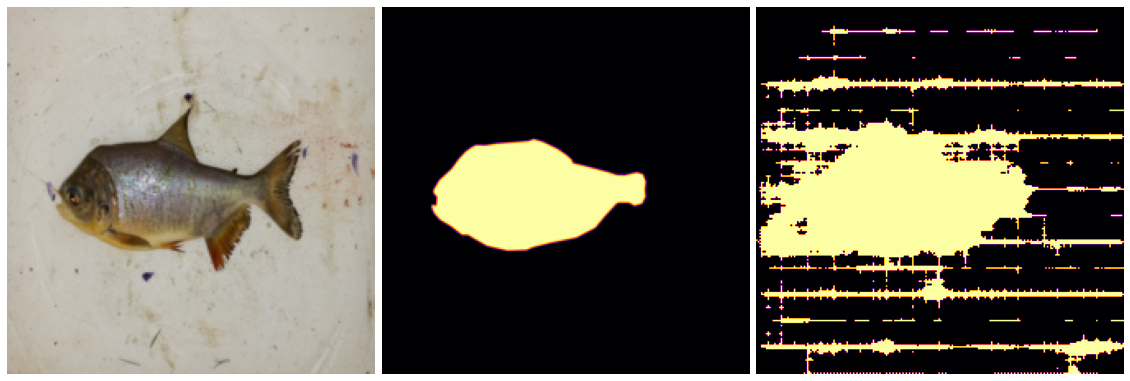

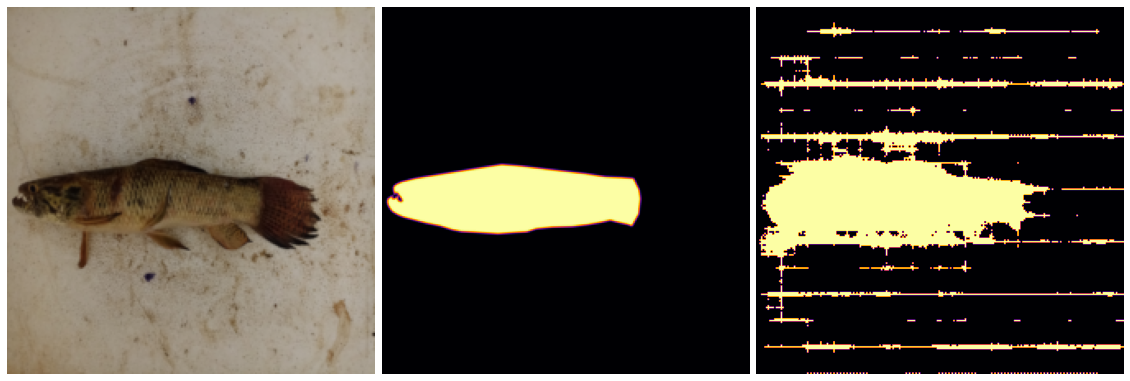

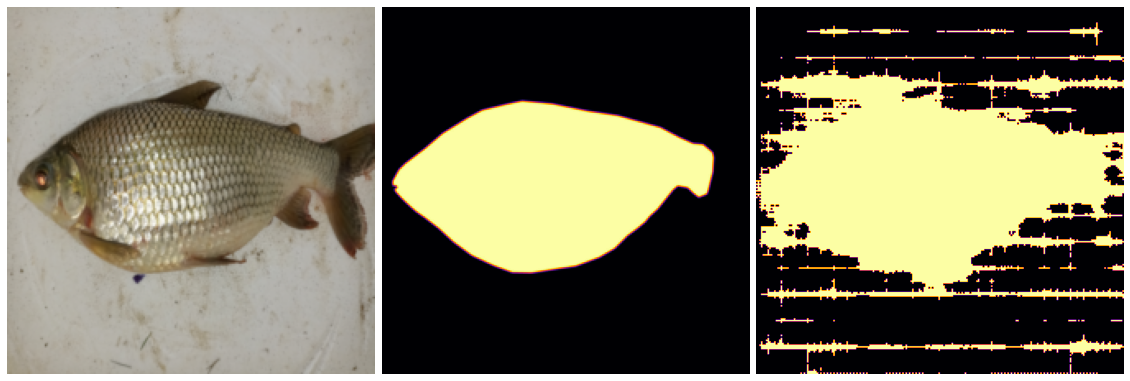

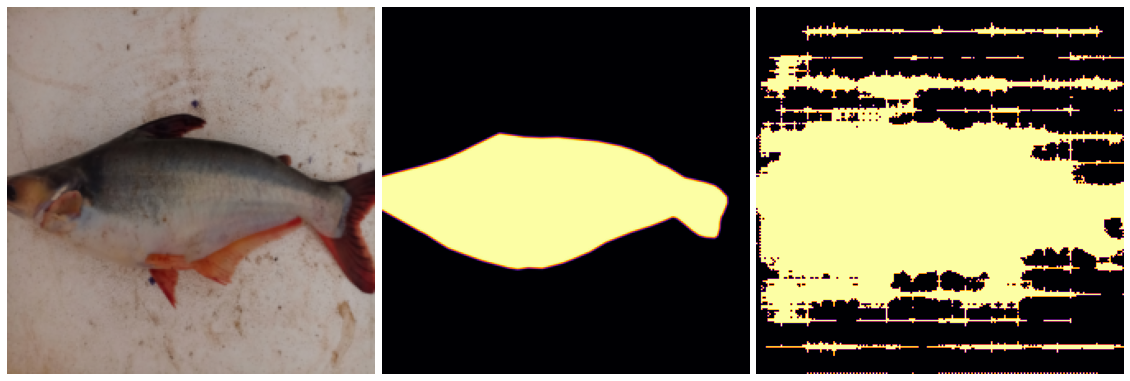

In [23]:

for index in range(len(y_pred)):
    plot([X_test[index], 
          y_test[index], 
          create_mask(y_pred_thresholded[index])], (1, 3))